Simon Vercaemer, doing the Gorilla assessment

First, import some stuff. I always do this alphabetically

In [1]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import timeit

Load the file and have a look

In [2]:
xlFlNm = 'data.xlsx'
df_f = pd.read_excel(xlFlNm, 0, engine='openpyxl') # forecasted Consumption
df_m = pd.read_excel(xlFlNm, 1, engine='openpyxl') # Meter list
df_r = pd.read_excel(xlFlNm, 2, engine='openpyxl') # Rates
df_r.fillna(np.inf, inplace=True) # replace the emply fields with infinities
    
print(df_f)
print(df_m)
print(df_r)

           Date    Meter ID         kWh
0    2020-10-01  1000000603   28.782474
1    2020-10-01    10588707  126.367711
2    2020-10-01    10626610  326.240595
3    2020-10-02  1000000603   26.690797
4    2020-10-02    10588707  118.322449
...         ...         ...         ...
2185 2022-09-29    10588707   77.744203
2186 2022-09-29    10626610  270.357196
2187 2022-09-30  1000000603   17.927143
2188 2022-09-30    10588707   73.335098
2189 2022-09-30    10626610  263.375674

[2190 rows x 3 columns]
     Meter ID Exit Zone  Annual Quantity (kWh)
0  1000000603       SC1                  12337
1    10588707       EM2                  75123
2    10626610       NW1                 151779
           Date Exit Zone  Annual Quantity (Min)  Annual Quantity (Max)  \
0    2020-04-01       EA1                      0                73200.0   
1    2020-04-01       EA2                      0                73200.0   
2    2020-04-01       EA3                      0                73200.0   
3    20

In [3]:
# make some shorter column names
mID = 'Meter ID'
EZ = 'Exit Zone'
AQ = 'Annual Quantity (kWh)'
AQmin = 'Annual Quantity (Min)'
AQmax = 'Annual Quantity (Max)'
rate = 'Rate (p/kWh)'

In [4]:
rdf = df_r[df_r[EZ] == 'SC1']
v = 751779
rdf = rdf[rdf[AQmin] < v]
rdf = rdf[rdf[AQmax] > v]
print(rdf)

           Date Exit Zone  Annual Quantity (Min)  Annual Quantity (Max)  \
99   2020-04-01       SC1                 732000                    inf   
213  2020-10-01       SC1                 732000                    inf   
327  2021-04-01       SC1                 732000                    inf   
441  2021-10-01       SC1                 732000                    inf   
555  2022-04-01       SC1                 732000                    inf   
669  2022-10-01       SC1                 732000                    inf   
783  2023-04-01       SC1                 732000                    inf   
897  2023-10-01       SC1                 732000                    inf   
1011 2024-04-01       SC1                 732000                    inf   

      Rate (p/kWh)  
99        0.243100  
213       0.243100  
327       0.243192  
441       0.243192  
555       0.253364  
669       0.253364  
783       0.261613  
897       0.261613  
1011      0.270020  


In [5]:
# a class that deals with one meter
class meter:
    def __init__(self, meterDataframe, row, verbose=False):
        if row >= len(meterDataframe.index):
            raise ValueError
        self.MetSeries = meterDataframe.iloc[row]
        self.metID = self.MetSeries[mID]
        self.Zone = self.MetSeries[EZ]
        self.Quant = self.MetSeries[AQ]
        self.row = row
        self.v = verbose
        
        if self.v:
            self.PrintMet()
            
    def PrintMet(self):
        print(f'{mID}: {self.metID}, {EZ}: {self.Zone},')
        print(f'{AQ}: {self.Quant}')
        
    def SetRates(self, ratesDataframe):
        self.rdf = ratesDataframe[ratesDataframe[EZ] == self.Zone]
        self.rdf = self.rdf[self.rdf[AQmin] < self.Quant]
        self.rdf = self.rdf[self.rdf[AQmax] > self.Quant]
        self.rdf = self.rdf[['Date', rate]]
        self.rdf.set_index('Date', inplace=True)
        if self.v:
            print(self.rdf)
        
    def SetConsumption(self, consDataframe):
        self.cdf = consDataframe[consDataframe[mID] == self.metID]
        self.cdf = self.cdf[['Date', 'kWh']]
        self.cdf.set_index('Date', inplace=True)
        if self.v:
            print(self.cdf)
            
    def GetDailyPrice(self):
        # match the rate dataframe with the forcated consumtion dataframe
        if not hasattr(self, 'cdf'):
            print('Set the consumption first')
            raise AttributeError
        if not hasattr(self, 'rdf'):
            print('Set the rates first')
            raise AttributeError
            
        # expland the price to daily
        rdf_rs = self.rdf.resample('D').ffill()
        
        # merge the rate and consumption frames
        mdf = pd.concat([rdf_rs, self.cdf], axis=1)
        mdf.dropna(inplace=True)
        # calculate the daily price
        mdf['Daily Cost (p)'] = mdf[rate]*mdf['kWh']
        # sum the daily price and total consumption
        self.totCost = np.sum(mdf['Daily Cost (p)'])*0.01
        self.totCons = np.sum(mdf['kWh'])
        
        if self.v:
            print(f'meter {self.metID} in exit zone {self.Zone} ' +
                  f'has an estimated consumption of {self.totCons:.2f} kWh, ' +
                  f'costing {self.totCost:.2f} pounds')
            
    def GetCostDataframe(self):
        if not hasattr(self, 'totCons'):
            self.GetDailyPrice()
            
        return pd.DataFrame({'Meter ID':self.metID,
                             'Total Estimated Consumption (kWh)':self.totCons,
                             'Total Cost (£)':self.totCost},
                            index=[self.row]).round(2)

Now use the class to process the provided meters.
Be smart and make it in a function at once, that'll help for step 4

In [6]:
def ProcessMeters(MeterDataFrame, ConsumptionDataFrame, RateDateFrame=df_r):
    CostDataFrame = None
    for index in range(len(MeterDataFrame.index)):
        m = meter(MeterDataFrame, index)
        m.SetRates(RateDateFrame)
        m.SetConsumption(ConsumptionDataFrame)
        meterCost = m.GetCostDataframe()
        if CostDataFrame is None:
            CostDataFrame = meterCost
        else:
            CostDataFrame = CostDataFrame.append(meterCost)
    return CostDataFrame

cost = ProcessMeters(df_m, df_f)
print(cost)

     Meter ID  Total Estimated Consumption (kWh)  Total Cost (£)
0  1000000603                            24674.0            8.27
1    10588707                           122450.0           28.50
2    10626610                           303558.0           88.24


Step 2: Write a function that generates a list of random meters of any size. Examples of valid Exit Zones can be found in the rate table. You may randomly generate the Annual Quantity.

In [7]:
def GenerateMeters(nMeters, RateDateFrame=df_r):
    ZoneList = RateDateFrame['Exit Zone'].tolist()
    # ZoneList has redundancy, but that's fine
    d = {'Meter ID':np.random.randint(10000000, 9999999999, size=nMeters),
         'Exit Zone':np.random.choice(ZoneList, size=nMeters),
         'Annual Quantity (kWh)':np.random.exponential(73200, size=nMeters)}
    return pd.DataFrame(data=d)

RandMeters = GenerateMeters(10)
print(RandMeters)

     Meter ID Exit Zone  Annual Quantity (kWh)
0  8879791237       NT3           13297.919624
1  7129137474       NW1           38001.141234
2  9812147977       NE2            9852.998175
3  3533197561       SO1          393341.164744
4  2189833632        LT           43479.315956
5  4257750315       WA1           16122.138906
6   438227646       WA1           10597.899955
7  8281222592       SW3           28200.701792
8  6133497821       EA2           47617.014557
9  2506233312       SE2            1485.378472


Step 3: Write a function that generates mock consumption data given a list of meters and a start and end date.

In [14]:
def GenerateConsumptionData(MeterData, startDate=datetime(2020, 4, 1), endDate=datetime(2024, 4, 1)):
    ConsData = None
    nDays = (endDate - startDate).days
    for index in range(len(MeterData.index)):
        mID = MeterData['Meter ID'][index]
        anCons = MeterData['Annual Quantity (kWh)'][index]
        # date range from https://stackoverflow.com/questions/12137277
        d = {'Date':np.arange(startDate, endDate, timedelta(days=1)).astype(datetime),
             'Meter ID':[mID]*nDays,
             'kWh':np.random.chisquare(anCons/365.25, size=nDays)}
        mdf = pd.DataFrame(data=d) # meter data frame
        if ConsData is None:
            ConsData = mdf
        else:
            ConsData = ConsData.append(mdf)
    ConsData.sort_values(by=['Date'], inplace=True, ignore_index=True)
    return ConsData

RandMeters = GenerateMeters(10)
print(RandMeters)
RandCons = GenerateConsumptionData(RandMeters, startDate=datetime(2020, 9, 5), endDate=datetime(2022, 10, 5))
print(RandCons)
        

     Meter ID Exit Zone  Annual Quantity (kWh)
0  5007023622       NT2          173800.163073
1  3864834606       NE2          139754.923911
2  7881208996       EM3           27265.543012
3   638869182       NT2           73545.423796
4  5847639994        LT            1823.703121
5  6016524465        LW          323020.173512
6  9917732908       NO2          252584.850975
7  9554182311       NE2          111096.336414
8  6087639986       NT1           62061.311457
9  8346354866        LW          107909.129602
           Date    Meter ID         kWh
0    2020-09-05  5007023622  449.569825
1    2020-09-05  5847639994    2.873971
2    2020-09-05  7881208996   74.937009
3    2020-09-05  6016524465  888.764724
4    2020-09-05  8346354866  255.512419
...         ...         ...         ...
7595 2022-10-04  7881208996   65.860076
7596 2022-10-04  3864834606  400.101492
7597 2022-10-04  5007023622  489.935353
7598 2022-10-04  6087639986  164.067301
7599 2022-10-04  8346354866  267.943881

[7

Step 4: Write a function that takes as an input a meter list and a consumption table and returns the Transportation cost table. Benchmark this function using meter lists of different sizes. Try longer periods as well? How does the function scale? 

I've been proactive and I already wrote this function (ProcessMeters). This next block is dedicated to benchmarking that code.

In [26]:
def ProfileProcessing(nMeters, nDays, nRepeats=10):
    setup  = f'RandMeters = GenerateMeters({nMeters})\n'
    setup += 'StartDate = datetime(2020, 4, 1)\n'
    setup += 'RandCons = GenerateConsumptionData(RandMeters, startDate=StartDate,'
    setup += f'                                   endDate=StartDate + timedelta(days=nDays))'
    
    stmt = 'ProcessMeters(RandMeters, RandCons)'
    t = timeit.timeit(stmt=stmt, setup=setup, globals=globals(), number=nRepeats)
    #print(f'{nRepeats} time(s) {nDays} days for {nMeters} meters took {t} s')
    return t/nRepeats

Text(0.5, 1.0, '10 meters')

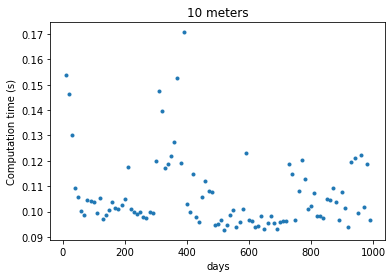

In [27]:
days = range(10, 1000, 10)
times = []
for nDays in days:
    times.append(ProfileProcessing(10, nDays))
    
plt.plot(days, times, '.')
plt.xlabel('days')
plt.ylabel('Computation time (s)')
plt.title('10 meters')

In [22]:
meters = range(10, 100, 10)
times = []
for nMeters in meters:
    times.append(ProfileProcessing(nMeters, 100))
    
plt.plot(meters, times, '.')
plt.xlabel('number of meters')
plt.ylabel('Computation time (s)')
plt.title('100 days')

Text(0.5, 1.0, '100 days')

Step 5: What are your observations after benchmarking? Are there any steps in the cost calculation that can be improved? How would you go about improving the performance of such a calculation?
 
 > What are your observations after benchmarking?
 
It seems like the code is remarkably stable over time and increases linearly with the number of meters.
This second part makes intuitive sense, since I wrote the code in such a way that each meter is treated separatly. It is currently executed one meter in a row, doubling the number of meters doubles the processing time.

Concerning the time over which the costs are calculated: these are still relatively short time periods, the longest I tested was only 1000 points, about 3 years worth of daily data. When minute or second interval data were to be considered (resp. 720 and 76400 times as much data), there might be an increase. Optimization by vectorization of searching, adding and multiplying can only go so far...

 > Are there any steps in the cost calculation that can be improved?
 
GetCostDataFrame is currently run in series, one meter after the other. Some gains could be had by running it in parralel for multiple meters. This will increase the speed by a factor roughly equal to the number of cores deployed, but it will esentially still scale linearly.

> How would you go about improving the performance of such a calculation?

I have not done a Valgrind-like time assessment of the code, some easily solvable bottlenecks might pop up. Further vectorization might be possible as well. It is also possible to deploy a just-in-time compilation package such as Numba to speed up things further (I have no practical experience with Numba, I just know it exists) 